# 1D dataset
##### The majority of codes except for the model and data preprocessing can be found on NPF ()
#####  Please also cite their work when

In [1]:
import os
import logging
import warnings
import torch
from tqdm import tqdm
import numpy as np
from utils.ntbks_helpers import get_all_gp_datasets
from utils.data import cntxt_trgt_collate
from functools import partial
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from utils.helpers import count_parameters
from npf import ELBOLossLNPF

from npf.neuralproc.gbconp import GlobalConvNP
from utils.train import train_models
from utils.evaluate import test_with_loglikelihood, quantify_global_uncertainty
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    get_all_indcs,
)
from skorch.callbacks import GradientNormClipping

### Basic setting

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
N_THREADS = 4
torch.set_num_threads(N_THREADS)
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)




### get dataset

In [3]:
gp_path = '/home/xuesongwang/PycharmProject/NPF/data/gp_dataset.hdf5'

# DATASETS
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets(gp_path)

### context-target split

In [4]:
# CONTEXT TARGET SPLIT
# 1d
get_cntxt_trgt_1d = cntxt_trgt_collate(
        CntxtTrgtGetter(
            contexts_getter=GetRandomIndcs(a=1, b=50), targets_getter=get_all_indcs,
            is_add_cntxts_to_trgts=True
        )
    )

### define model

In [5]:
# 1D
########### Original  #################################
R_DIM = 128
MODEL_KWARGS = dict(
    is_q_zCct=True,
    n_z_samples_train=4,
    n_z_samples_test=4,
    r_dim=R_DIM,
    z_dim=R_DIM//2,
    # z_dim = 4,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)

# 1D case
model_1d = partial(
    GlobalConvNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    # CNN=partial(
    #     CNN,
    #     n_channels=R_DIM,
    #     Conv=torch.nn.Conv1d,
    #     Normalization=torch.nn.BatchNorm1d,
    #     n_blocks=2,
    #     kernel_size=19,
    #     **CNN_KWARGS,
    # ),
    decoder_CNN=partial(
        CNN,
        n_channels=R_DIM,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=4,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **MODEL_KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")


Number Parameters (1D): 295,684


### load trainer

In [7]:
KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF, # NPML
    chckpnt_dirname="results/pretrained/",
    device=device,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=32,  # smaller batch because multiple samples
    callbacks=[
        GradientNormClipping(gradient_clip_value=1)
    ],  # clipping gradients can stabilize training
)

trainers_1d = train_models(
        gp_datasets,
        {"GBCoNP": model_1d},
        test_datasets=gp_test_datasets,
        iterator_train__collate_fn=get_cntxt_trgt_1d,
        iterator_valid__collate_fn=get_cntxt_trgt_1d,
        max_epochs=5,
        **KWARGS
    )



--- Loading Periodic_Kernel/GBCoNP/run_0 ---

Periodic_Kernel/GBCoNP/run_0 | best epoch: 84 | train loss: -74.7347 | valid loss: -127.0734 | test log likelihood: 64.4905


### Test target log-likelihood

In [ ]:
for k, trainer in trainers_1d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
#     df.to_csv('results/csv/' + modelname + '_' + kernel + 'global_uncertainty.csv', index=False)
    df = test_with_loglikelihood(gp_test_datasets[kernel], trainer)

### Evaluate the scale of global uncertainty ($\mu_z, \sigma_z$ )

In [8]:
for k, trainer in trainers_1d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
    df = quantify_global_uncertainty(gp_test_datasets[kernel], trainer)


testing on: Periodic_Kernel


100%|██████████| 157/157 [00:05<00:00, 29.17it/s]

for 6 runs, mean: -0.0049, std:0.2063


### Model prediction sample

  0%|          | 0/157 [00:00<?, ?it/s]


Now with the dataset: Periodic_Kernel


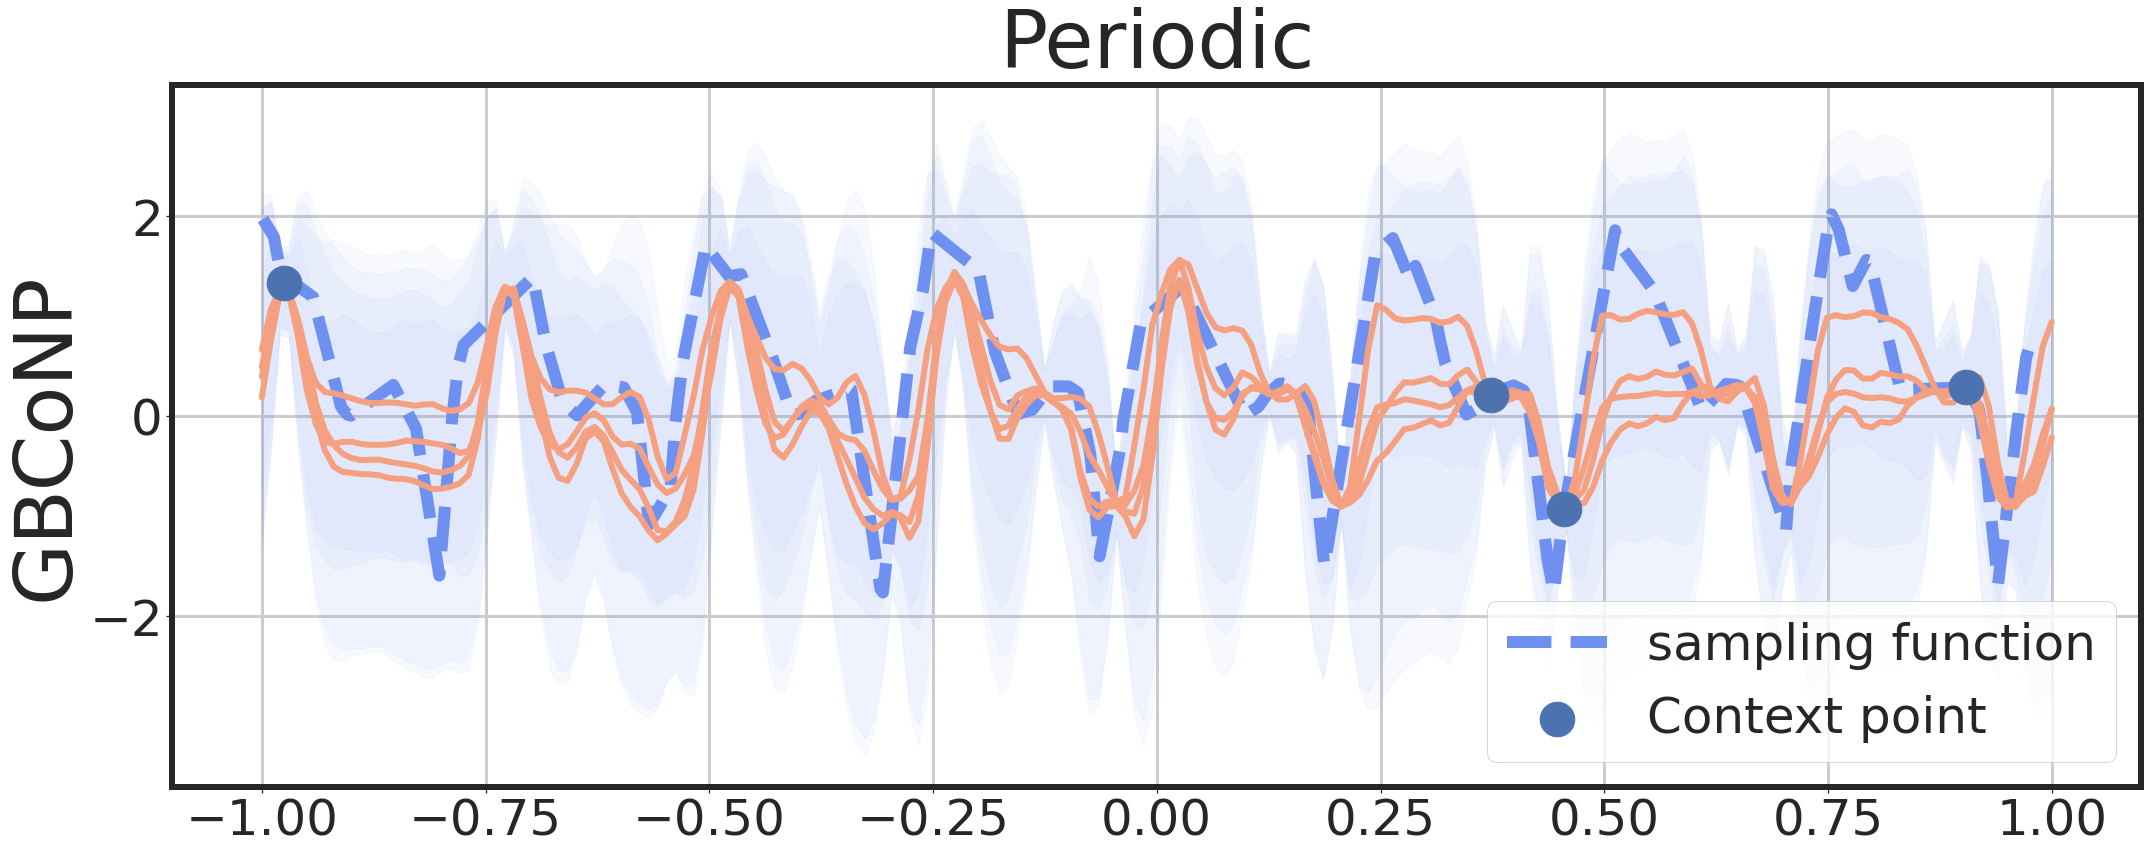

In [8]:
def batch2numpy(x):
    return x.detach().cpu().numpy()


def plot_by_dataset(trainers_1d, data, namelist, modellist, num_context =15, num_total = 40):
    import seaborn as sns
    import matplotlib.pyplot as plt
    def generate_z_sample(z_dist, n_z_sample=1):
        z_mean = z_dist.mean
        z_std = z_dist.stddev
        z_range = np.arange(0, 2, 2/(n_z_sample//2))
        z_samples = [z_mean + z_std*i for i in z_range] + [z_mean - z_std*i for i in z_range]
        z_samples = torch.stack(z_samples, dim=0)
        return z_samples

    def sample_with_global_uncertainty(model, modelname, X_cntxt, Y_cntxt, X_trgt, Y_trgt=None):
        X_cntxt = model.x_encoder(X_cntxt)
        X_trgt = model.x_encoder(X_trgt)
        R = model.encode_globally(X_cntxt, Y_cntxt)
        if model.encoded_path in ["latent", "both"]:
            model.n_z_samples = model.n_z_samples_test
            z_samples, z_samples_mean, q_zCc, q_zCct = model.latent_path(X_cntxt, R, X_trgt, Y_trgt)
            z_samples = generate_z_sample(q_zCc, z_samples.shape[0])
            if modelname == 'ConvNP':
                z_samples = z_samples.repeat(1, 1,  R.shape[-2], 1)
        else:
            z_samples, z_samples_mean, q_zCc, q_zCct = None, None, None, None

        # size = [n_z_samples, batch_size, *n_trgt, r_dim]
        R_trgt = model.trgt_dependent_representation(X_cntxt, z_samples, R, X_trgt)

        # p(y|cntxt,trgt)
        # batch shape=[n_z_samples, batch_size, *n_trgt] ; event shape=[y_dim]
        p_yCc = model.decode(X_trgt, R_trgt)
        return p_yCc

    sns.set_theme(style="ticks", color_codes=True)

    for col, (dataname, dataset) in enumerate(data.items()):

        fig, axs = plt.subplots(len(modellist), 1,
                                figsize=(30, int(12 * len(modellist))))
        # load data
        #get one batch
        for batch in tqdm(next(iter(trainers_1d.values())).get_iterator(dataset, training=False)):
            x_context = batch[0]['X_cntxt'].to(device)
            y_context = batch[0]['Y_cntxt'].to(device)
            x_target = batch2numpy(batch[0]['X_trgt'][0])
            y_target = batch2numpy(batch[0]['Y_trgt'][0])
            sort_target_index = np.argsort(x_target[:,0])
            x_target = x_target[sort_target_index]
            y_target = y_target[sort_target_index]

            if np.random.rand() >0.5:
                break
        for row, modelname in enumerate(modellist):
            ax = axs if len(modellist) == 1 else axs[row]
            direct = dataname + '/' + modelname + '/run_0'  # look up model by modelname and dataname

            # load model
            # temp = trainers_1d[direct]
            model = trainers_1d[direct].module_.eval().to(device)

            x_min = -1
            x_max = 1

            print("Now with the dataset:", dataname)

            x_all = torch.linspace(x_min, x_max, 200)[None, :, None].to(device)

            dist, sample, z_dist, _ = model(x_context, y_context, x_all.repeat([x_context.shape[0], 1, 1]))

            # dist = sample_with_global_uncertainty(model, modelname, x_context, y_context, x_all.repeat([x_context.shape[0], 1, 1]))
            y_mean = dist.mean[:,0,:,:] # only the first batch
            y_std = dist.stddev[:,0,:,:]
            # Plot context set
            ax.scatter(batch2numpy(x_context[0]), batch2numpy(y_context[0]),
                           label='Context point',
                           s=1200, zorder=2)
            # ax.scatter(batch2numpy(x_target[0]), batch2numpy(y_target[0]), label='Target point',
            #                       marker = 'X', s=800, zorder=2)
            ax.plot(x_target,y_target, linewidth=12, zorder=1, alpha= 1,
                        linestyle='--',color="#6D90F1", label='sampling function')

            # plot prediction
            linecolor = '#F5A081'
            fill_color = '#6D90F1'
            if y_mean.shape[0] != 1: # NP based models
                sample_size = y_mean.shape[0]

            y_sample = batch2numpy(y_mean.squeeze(dim=-1))
            y_std_sample = batch2numpy(y_std.squeeze(dim=-1))

            # y_sample, y_std_sample = latent_sample(x_context, y_context, x_all.repeat([x_context.shape[0], 1, 1]), model, sample_size=sample_size)
            # y_sample = sample_prediction(y_mean.squeeze(), y_std.squeeze(), 1)

            ax.plot(batch2numpy(x_all.squeeze()), y_sample.T, linewidth=6, zorder=1, alpha= 8/sample_size,
                        color=linecolor)

            for sample_i in range(y_mean.shape[0]):
                if y_mean.shape[0] == 1: # CNP based methods, make sure the filled color look alike the NP based methods
                    for _ in range(sample_size):
                        ax.fill_between(batch2numpy(x_all.squeeze()),
                                        y_sample[0] + 2 * y_std_sample[0],
                                        y_sample[0] - 2 * y_std_sample[0],
                                        alpha=2 / (10 * sample_size),
                                        color=fill_color)
                else:
                    ax.fill_between(batch2numpy(x_all.squeeze()),
                                        y_sample[sample_i] + 2 * y_std_sample[sample_i],
                                        y_sample[sample_i] - 2 * y_std_sample[sample_i],
                                        alpha=2/(10*sample_size),
                                        color=fill_color)

            # axs[i].xlabel("Location", size=60)
            ax.set_ylabel("%s" % modelname, size=80)
            if row == 0: # first ax
                ax.set_title(dataname.split('_')[0], {'fontsize': 80})# remove _kernel
            ax.legend(prop={'size': 50}, loc='lower right')
            ax.grid("on", linewidth=3)

            # ax.tick_params(axis="x", labelsize=50)
            [i.set_linewidth(6) for i in ax.spines.values()]  # change subplot border line width
            ax.tick_params(labelsize=50)
        plt.tight_layout()

        # fig.savefig('results/imgs/'+dataname + ".png")
        plt.show()


plot_by_dataset(trainers_1d, gp_test_datasets, namelist=['GBCoNP'], modellist=['GBCoNP'])

### Manipulation of the functional priors
have to reload model as the dimension of the global uncertainty is reduced to 4 for visualzation

In [105]:
def compute_likelihood(mean, var, y_target, issum=True):
    from torch.distributions import Normal
    dist = Normal(loc=mean, scale=var)

    if mean.shape[0] != y_target.shape[0]:  # z_sample
        y_target = y_target.expand(mean.size())
    log_prob = dist.log_prob(y_target)
    loss = torch.mean(log_prob, dim=-2)[:, 0]
    n_row = int(np.sqrt(loss.shape[0]))
    loss = batch2numpy(loss.reshape((n_row, n_row)))
    return loss

def visualize_global_uncertainty(trainers_1d, data, namelist, modellist, n_subplot=1, sample_size=10):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from torchvision.utils import make_grid
    sns.set_theme(style="ticks", color_codes=True)

    def generate_z_sample(z_dist, n_z_sample=1):
        z_mean = z_dist.mean
        z_std = z_dist.stddev
        bs, *data_shape, dim = z_mean.shape
        z_grid = z_mean[None, None, :].repeat(n_z_sample, n_z_sample, 1, 1, 1)
        # rand_index = np.random.choice(np.arange(0, dim, 1), 2, replace=False)  # non-replacement shuffle
        rand_index = [0, 2]
        print("index combo:", rand_index)
        rand_index = np.random.randint(0, dim, 2)
        x = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample), loc=z_mean[0,0,rand_index[0]].detach().cpu().numpy(),
                     scale=20*z_std[0, 0, rand_index[0]].detach().cpu().numpy())
        y = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample), loc=z_mean[0,0,rand_index[1]].detach().cpu().numpy(),
                     scale=20*z_std[0, 0, rand_index[1]].detach().cpu().numpy())
        l_x = x.shape[0]
        l_y = y.shape[0]
        x_grid = np.repeat(x, l_y).reshape(-1, 1)
        y_grid = np.tile(y, l_x).reshape(-1, 1)
        _z = np.concatenate([x_grid, y_grid], axis=1)
        for i in range(n_z_sample):
            for j in range(n_z_sample):
                z_grid[i, j, :, :, rand_index[0]] = _z[i*n_z_sample+j, 0]
                z_grid[i, j, :, :, rand_index[1]] = _z[i * n_z_sample + j, 1]
        z_samples = z_grid.view(n_z_sample*n_z_sample, bs, *data_shape, dim)
        return z_samples

    def sample_with_global_uncertainty(model, modelname, X_cntxt, Y_cntxt, X_trgt, Y_trgt=None, sample_size=1):
        X_cntxt = model.x_encoder(X_cntxt)
        X_trgt = model.x_encoder(X_trgt)
        R = model.encode_globally(X_cntxt, Y_cntxt)


        if model.encoded_path in ["latent", "both"]:
            model.n_z_samples = model.n_z_samples_test
            z_samples, z_samples_mean, q_zCc, q_zCct = model.latent_path(X_cntxt, R, X_trgt, Y_trgt)
            temp1 = q_zCc.mean.detach().cpu().numpy()
            temp2 = q_zCc.stddev.detach().cpu().numpy()
            z_samples = generate_z_sample(q_zCc, sample_size)
            if 'Co' in modelname:
                z_samples = z_samples.repeat(1, 1, R.shape[-2], 1)
        else:
            z_samples, z_samples_mean, q_zCc, q_zCct = None, None, None, None

        # size = [n_z_samples, batch_size, *n_trgt, r_dim]
        R_trgt = model.trgt_dependent_representation(X_cntxt, z_samples, R, X_trgt)

        # p(y|cntxt,trgt)
        # batch shape=[n_z_samples, batch_size, *n_trgt] ; event shape=[y_dim]
        p_yCc = model.decode(X_trgt, R_trgt)
        return p_yCc

    for col, (dataname, dataset) in enumerate(data.items()):
        linecolor = '#F5A081'
        fill_color = '#6D90F1'
        n_row = 7
        n_col = 7
        fig, axs = plt.subplots(n_row, n_col, figsize=(50, 20))
        # load data
        # get one batch
        for batch in tqdm(next(iter(trainers_1d.values())).get_iterator(dataset, training=True)):
            x_context = batch[0]['X_cntxt'].to(device)
            y_context = batch[0]['Y_cntxt'].to(device)
            x_target = batch[0]['X_trgt'].to(device)
            y_target = batch[0]['Y_trgt'].to(device)
            if np.random.rand() > 0.5:
                break

        for row, modelname in enumerate(modellist):
            x_context_cp = x_context.clone()
            y_context_cp = y_context.clone()
            x_target_cp = x_target.clone()
            y_target_cp = y_target.clone()

            print("now with dataset:%s, model:%s" % (dataname, modelname))
            direct = dataname + '/' + modelname + '/run_0'
            model = trainers_1d[direct].module_.eval().to(device)

            dist = sample_with_global_uncertainty(model, modelname, x_context_cp, y_context_cp, x_target_cp, sample_size=sample_size)
            # dist, sample, z_dist, _ = model(x_context_cp, y_context_cp, x_target_cp)
            # [masked_context, predicted_mean*7, predicted_std]
            y_mean = dist.mean[:, 0, :, :]  # (n_z_sample, n_target, y_dim)
            y_std = dist.stddev[:, 0, :, :]

            loglikelihood = compute_likelihood(y_mean, y_std, y_target_cp, issum=False)
            
            for i in range(n_row):
                for j in range(n_col):
                    ax = axs[i, j]
                    ax.scatter(batch2numpy(x_context_cp[0]), batch2numpy(y_context_cp[0]),
                       s=500, zorder=2)

                    ax.plot(batch2numpy(x_target_cp[0].squeeze()), batch2numpy(y_mean[i*n_row + j]), linewidth=10, zorder=1,
                            color=linecolor)
                    ax.set_xticks([]) # remove xtick, y_tick
                    ax.set_yticks([])
                    [i.set_linewidth(10) for i in ax.spines.values()] # change subplot border line width

        plt.tight_layout()
        # fig.savefig('results/imgs/' + dataname + ".png")
        plt.show()
        plt.close(fig)
        
        # draw log-likelihood heatmap
        fig, axs = plt.subplots(figsize=(50, 20))
        sns.set(font_scale=2) # font size 2
        res = sns.heatmap(loglikelihood,   annot=True, 
                    annot_kws={"size":50},
                    fmt=".2f")
        res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 50)
        res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 50)
        

In [106]:
sample_size = 7
R_DIM = 128
KWARGS = dict(
    is_q_zCct=True,  # will use NPVI => posterior sampling
    n_z_samples_train=sample_size,
    n_z_samples_test=sample_size,
    r_dim=R_DIM,
    z_dim=4,
    # z_dim=R_DIM//2,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


model_1d = partial(
    GlobalConvNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    decoder_CNN=partial(
        CNN,
        n_channels=R_DIM,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=4,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

modeldict = dict()
modelname = 'GBCoNP_zdim4'
modeldict[modelname] = model_1d




--- Loading Periodic_Kernel/GBCoNP_zdim4/run_0 ---

Periodic_Kernel/GBCoNP_zdim4/run_0 | best epoch: 33 | train loss: -37.148 | valid loss: -77.6402 | test log likelihood: 31.5453


  0%|          | 0/10000 [00:00<?, ?it/s]


now with dataset:Periodic_Kernel, model:GBCoNP_zdim4
index combo: [0, 2]


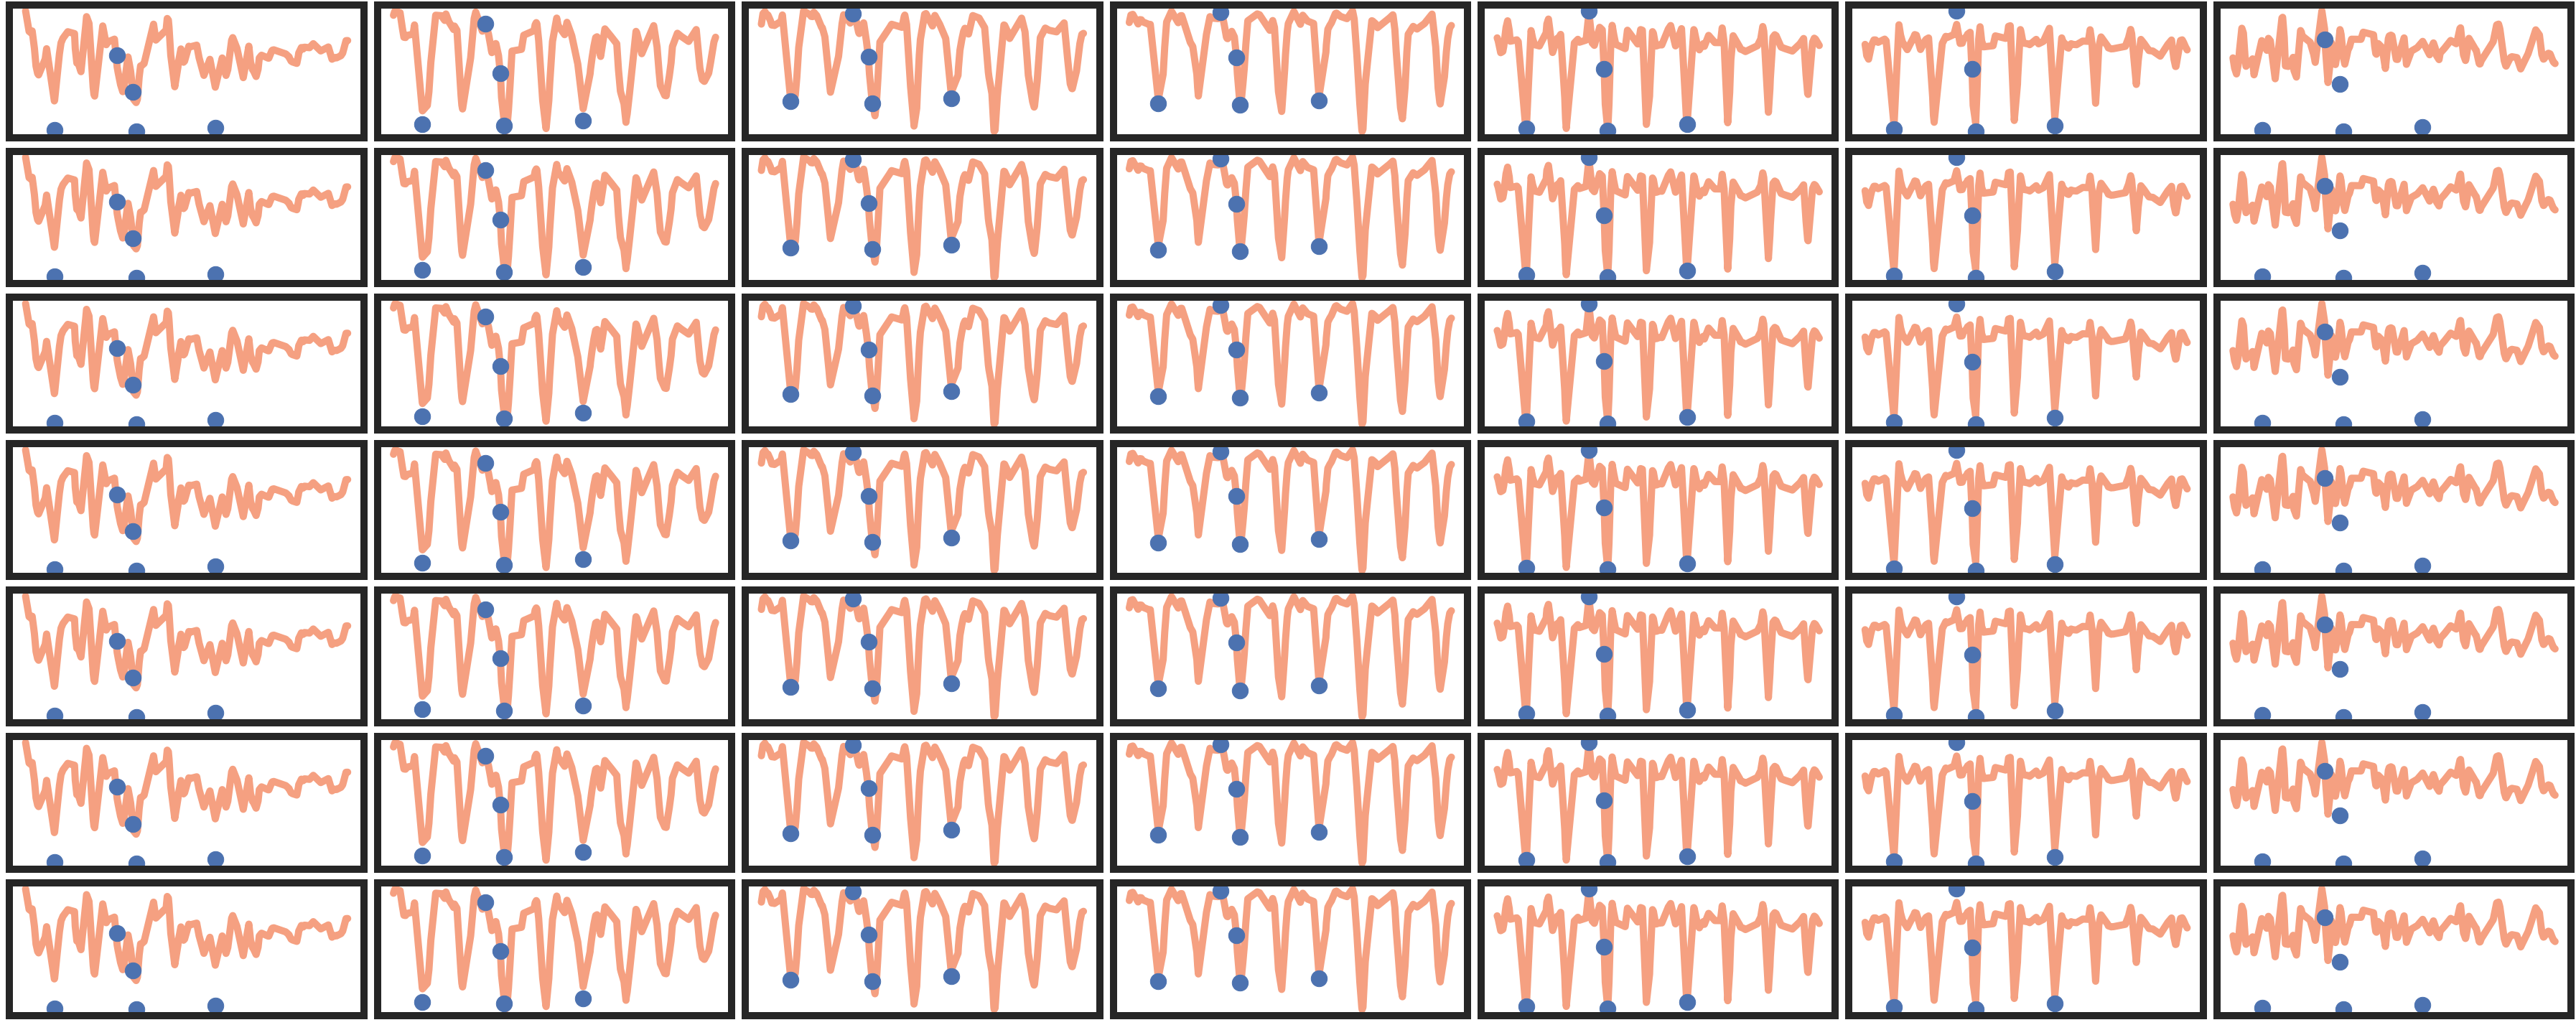

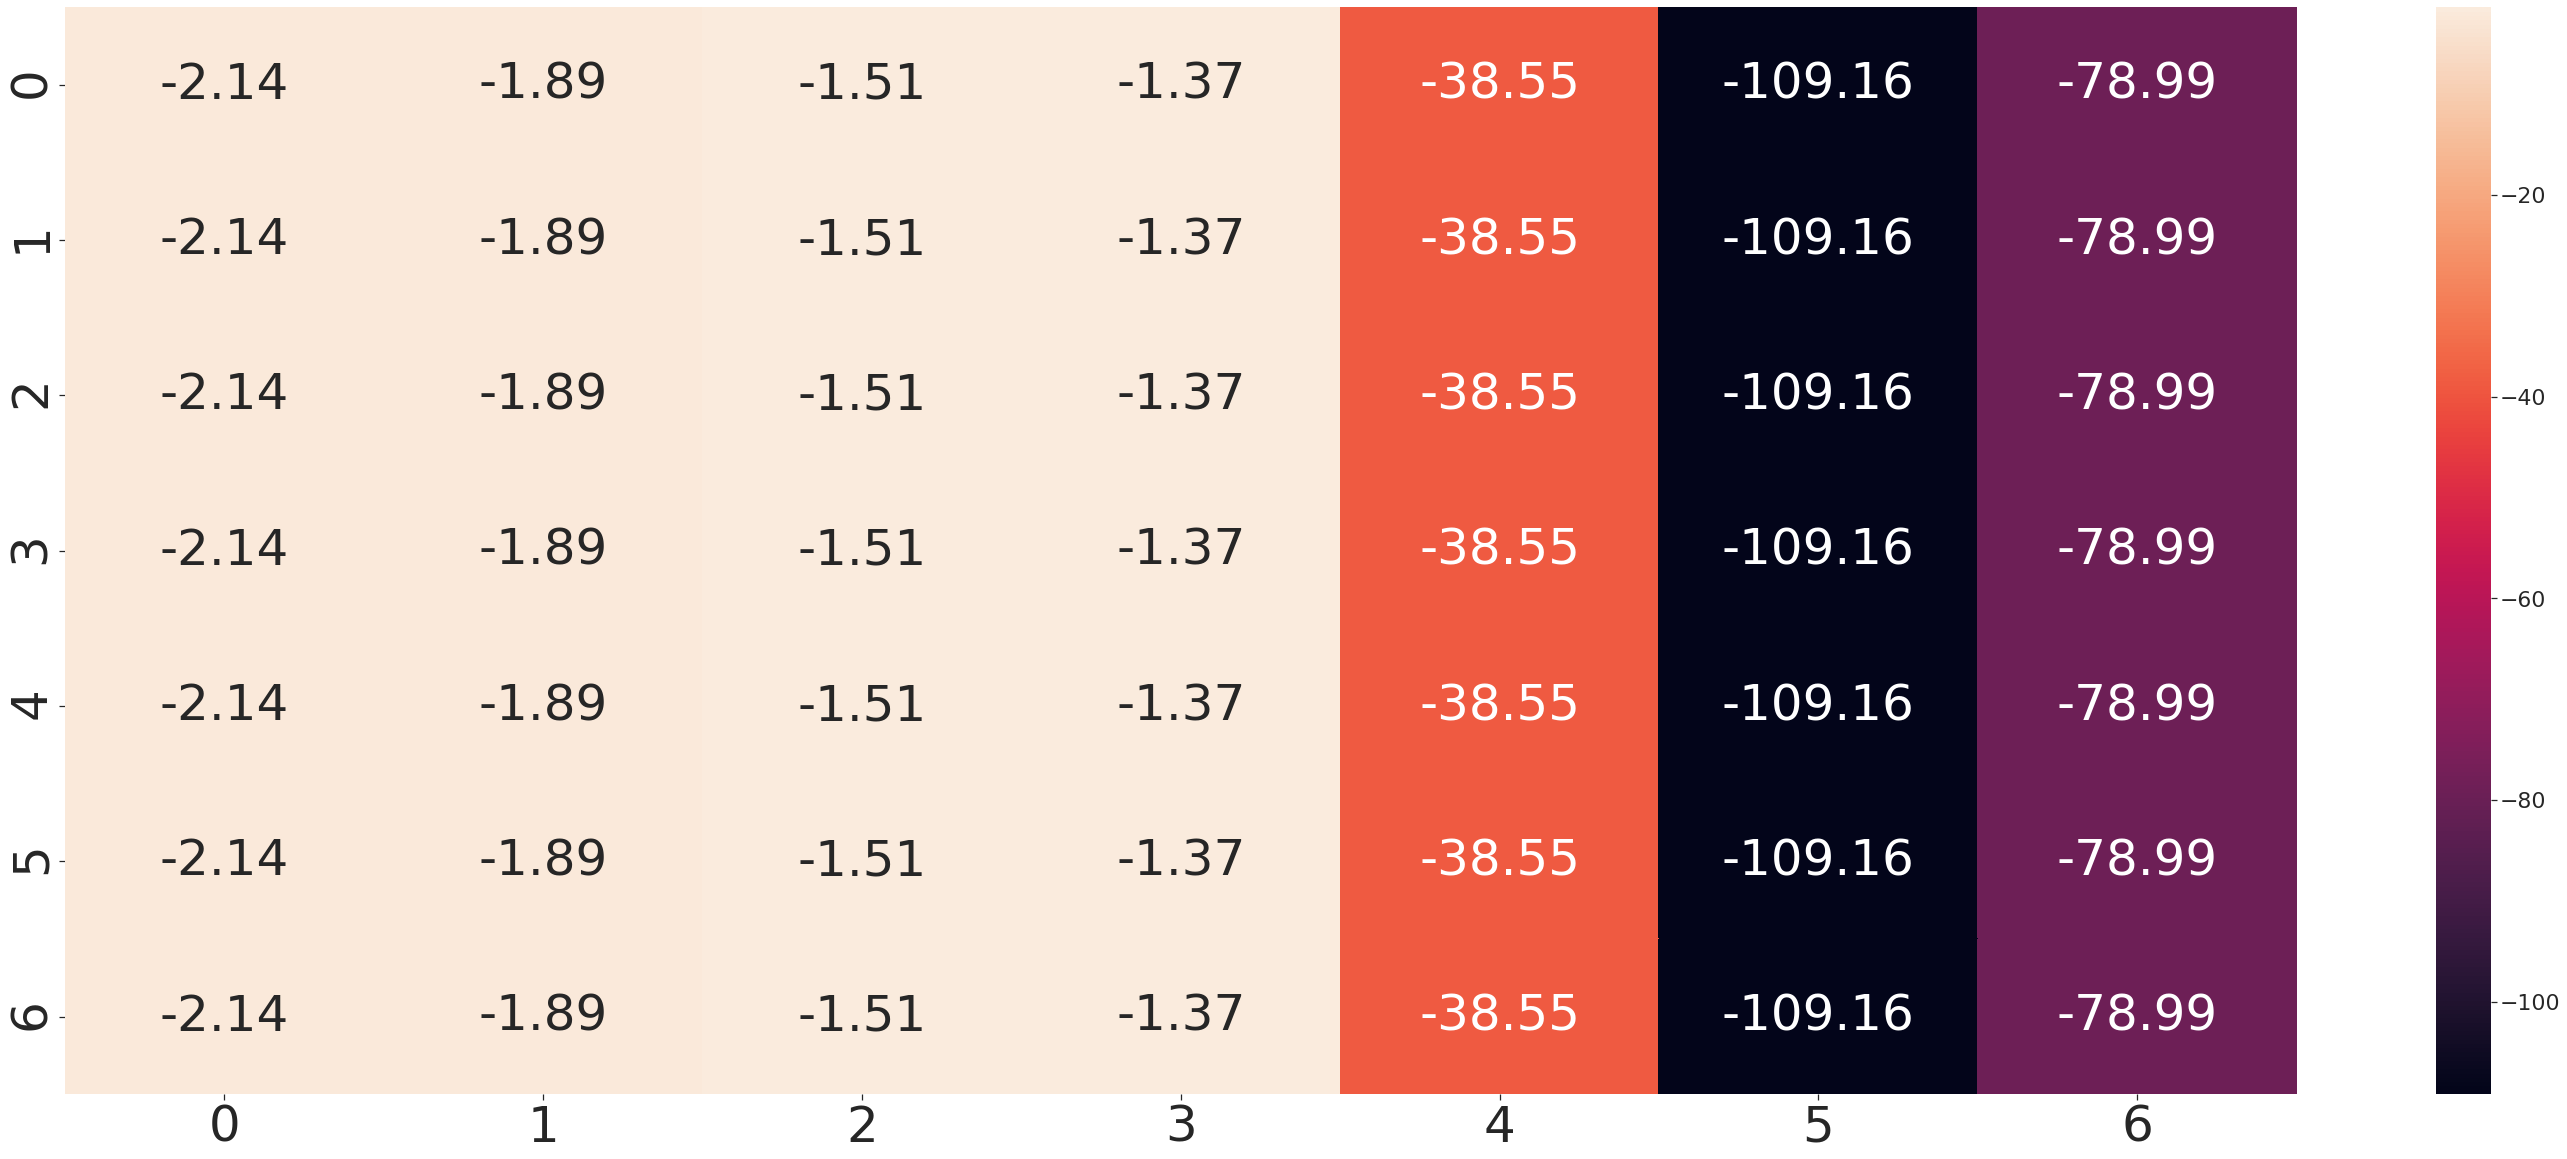

In [108]:
KWARGS = dict(
        is_retrain=False,  # whether to load precomputed model or retrain
        criterion=ELBOLossLNPF,
        chckpnt_dirname="results/pretrained/",
        device=device,  # use GPU if available
        batch_size=1,
        lr=1e-3,
        decay_lr=10,  # decrease learning rate by 10 during training
        # seed = 123,
    )


get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=4, b=8), targets_getter=get_all_indcs,
        # contexts_getter=GetCustomizedIndcs(), targets_getter=get_all_indcs,
        is_add_cntxts_to_trgts=False)
)

# 1D
trainers_1d = train_models(
    gp_test_datasets,
    modeldict,
    test_datasets=gp_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)

visualize_global_uncertainty(trainers_1d, gp_test_datasets, namelist=['GBCoNP'], modellist=['GBCoNP_zdim4'], sample_size=sample_size)